<h2>Analyzing CIA The World Factbook [SQL + Python]</h2>
Today we are examining the statistics of each country on Earth and this data is collected by the CIA who has stored this in their <a href = "https://www.cia.gov/library/publications/the-world-factbook/">The World Factbook</a>. The World Factbook contains information such as "the history, people and society, government, economy, energy, geography, communications, transportation, military, and transnational issues for 267 world entities." and it is our mission to extrapolate any notable statistics, trends, or relationships. Here, we are going to use SQL in Python for this analysis to practice extrapolating the above said mission tasks.

<h2>Importing Modules</h2>

In [17]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

<h2>Importing the database</h2>
NOTE: The SQLite database for The World Factbook ('factbook.db') can be downloaded from this <a href = "https://github.com/factbook/factbook.sql/releases">Github Repo</a>.

In [18]:
# set up the connection
conn = sqlite3.connect("factbook.db")
q = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


<b>Comment:</b> Here, we see that there is two tables for this databse and the one we need is the 'facts' table. Now, we should make a query to display the first 5 rows of the data.

<h2>Display the data</h2>


In [19]:
# print first 5 rows of the data
conn = sqlite3.connect("factbook.db")
query = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(query, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


<h2>Summary Statistics for each Country</h2>
First, our goal is to get the countries with the minimum and maximum population as well as countries with the highest and lowest population growth.

In [20]:
# get the country with the minimum population
query = """SELECT name, population, population_growth
           FROM facts
           WHERE name != 'World' AND
                 population = (SELECT MIN(population) FROM facts WHERE name != 'World');
         """
pd.read_sql_query(query, conn)

,name,population,population_growth
0,Antarctica,0,None


<b>Comment:</b> Antarctica has exactly 0 poulation, which makes sense as it is usually not inhabited except for foreign scientific research teams who have set the bases around the land.

In [21]:
# get the country with the maximum population 
query = """SELECT name, population, population_growth
           FROM facts
           WHERE name != 'World' AND
                 population = (SELECT MAX(population) FROM facts WHERE name != 'World');
         """
pd.read_sql_query(query, conn)

,name,population,population_growth
0,China,1367485388,0.45


<b>Comment:</b> China claims number 1 for having the highest populace in the entire world.

In [22]:
# get the country with the minimum population_growth
query = """SELECT name, population, population_growth
           FROM facts
           WHERE name != 'World' AND
                 population_growth = (SELECT MIN(population_growth) FROM facts WHERE name != 'World');
         """
pd.read_sql_query(query, conn)

,name,population,population_growth
0,Holy See (Vatican City),842,0.0
1,Cocos (Keeling) Islands,596,0.0
2,Greenland,57733,0.0
3,Pitcairn Islands,48,0.0


<b>Comment:</b> There is 4 countries, Vatican City, Cocos Islands, Greenland and the Pitcairn Islands who have 0 percent population growth which implies their population is dimishing, possibly due to mortality or departures from the civilians to other places.

In [23]:
# get the country with the maximum population_growth
query = """SELECT name, population, population_growth
           FROM facts
           WHERE name != 'World' AND
                 population_growth = (SELECT MAX(population_growth) FROM facts WHERE name != 'World');
         """
pd.read_sql_query(query, conn)

,name,population,population_growth
0,South Sudan,12042910,4.02


<b>Comment:</b> South Sudan is the country that shows the strongest population growth with 4.02 percent per year.

<h2>Visualising the population statistics using histograms</h2>
Here, we are interested in generating histograms for all the countries except for the 'Antartica' and 'World' rows because the the first one has 0 population so no interesting deductions there and the 'World' row is just the sum of the world's population (not a country). The columns of interest here are the population variables (population and population_growth) and the birth and death rates (birth_rate and death_rate).

In [24]:
# create the query table
query = """SELECT population, population_growth, birth_rate, death_rate 
           FROM facts
           WHERE name != 'World' OR name != 'Antarctica'
        """
rates = pd.read_sql_query(query, conn)
rates.head(5)

,population,population_growth,birth_rate,death_rate
0,32564342.0,2.32,38.57,13.89
1,3029278.0,0.30,12.92,6.58
2,39542166.0,1.84,23.67,4.31
3,85580.0,0.12,8.13,6.96
4,19625353.0,2.78,38.78,11.49


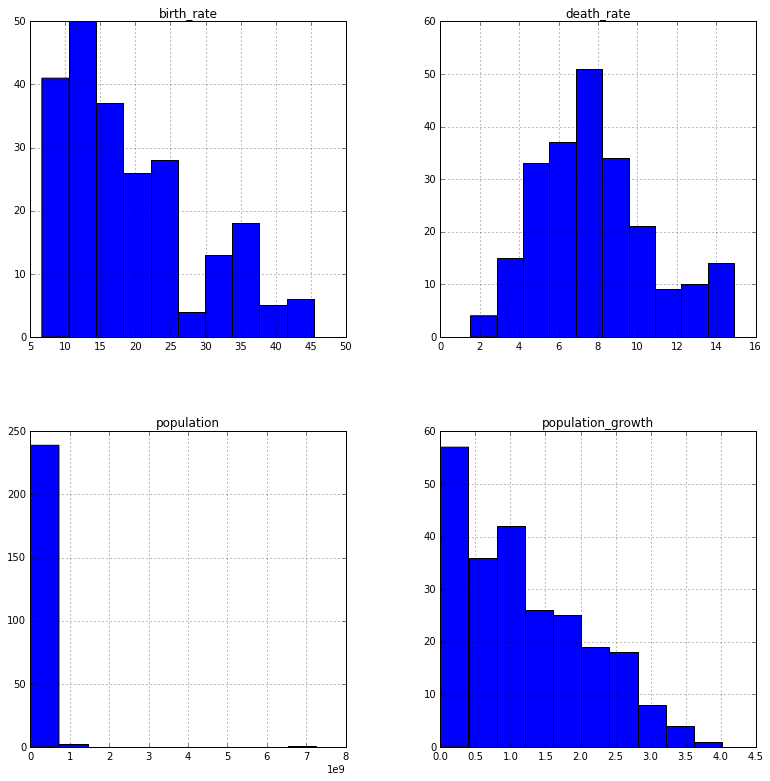

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# display a 2 by 2 histogram of the four variables
rates.hist(figsize = [13,13])
plt.show()

<b>Comment:</b> For the Birth Rates (births a year per 1,000 people), most countries have a birth rate around 5-25 births per 1000 people as seen by the right skewed distribution. The death rate (death a year per 1,000 people) on the other hand looks normally distributed, accounting for all the countries. Most countries have a population that is between 0 and 1 billion except for the outliers such as China. Lastly, the distribution of the population_growth is right skewed and thus there is less countries with a high population growth with the maximum being 4.2% population growth, which we found out was South Sudan. 

<h2>Finding the population densities</h2>
Now, we find the population density, which is defined as the ratio of the population with respect to the land area. To verify the accuracy of the population density, we can check and compare against the results from <a href = "https://simple.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density">Wikipedia</a>. From our data, that means we mind get the ratio of the columns 'population' and 'area_land'.

In [26]:
# get the country and its population density
query = """
        SELECT name, CAST(population as Float)/CAST(area_land as Float) as population_density
        FROM facts
        """
pop_density = pd.read_sql_query(query, conn)
pop_density.head(10)

,name,population_density
0,Afghanistan,49.927697
1,Albania,110.565662
2,Algeria,16.602211
3,Andorra,182.863248
4,Angola,15.741841
5,Antigua and Barbuda,209.131222
6,Argentina,15.870225
7,Armenia,108.370812
8,Australia,2.961485
9,Austria,105.107041


<b>Comment:</b> If we compare the population density we calculated with the estimated population density from Wikipedia. For example lets get the population densities of the first three countries Afghanistan, Albania and Algeria from the Wikipedia page.

<u1>
Population Densities:
<li>Afghanistan - 49 (population/km^2)</li>
<li>Albania - 100 (population/km^2)</li>
<li>Algeria - 18 (population/km^2)</li>
<u1>

Thus, it is close to the numbers we have above and can conclude that we have made the correct calculations.

<h2>Histogram of the population densities</h2>
Now, we visualise the distriution of our population density data:

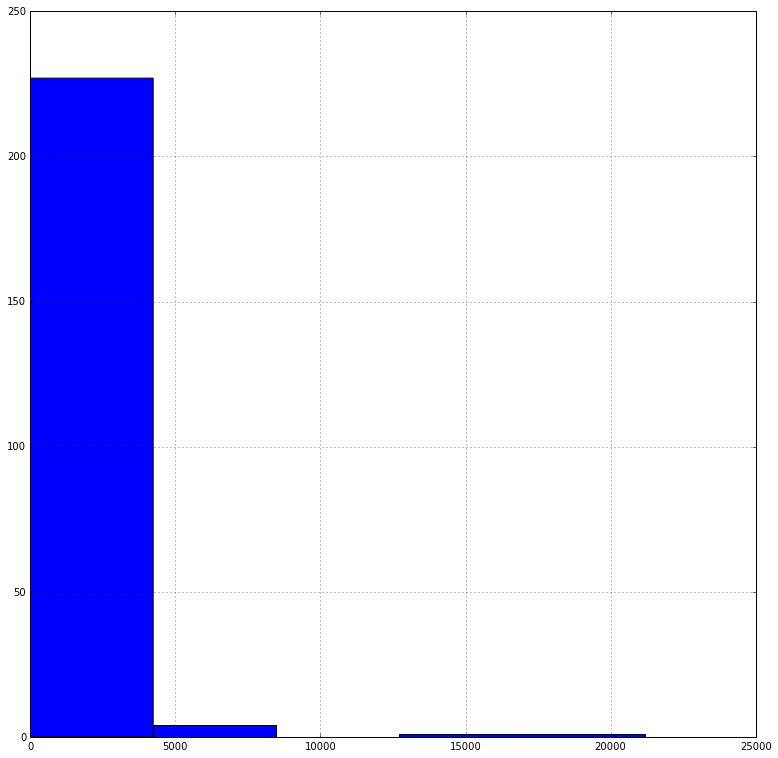

In [30]:
# histogram of the population densities for all countries and the world
pop_density['population_density'].hist(figsize = [13,13], bins = 5)
plt.show()

<h2>Water to land ratio for each country</h2>
Now, we try to find the water area to land area ratio for each country and the histogram of this distribution.

In [28]:
# get the country and its water to land ratio
query = """
        SELECT name, CAST(area_water as Float)/CAST(area_land as Float) as water_land_ratio
        FROM facts
        """
water_land_ratio = pd.read_sql_query(query, conn)
water_land_ratio.head(10)

,name,water_land_ratio
0,Afghanistan,0.000000
1,Albania,0.049274
2,Algeria,0.000000
3,Andorra,0.000000
4,Angola,0.000000
5,Antigua and Barbuda,0.000000
6,Argentina,0.015972
7,Armenia,0.054604
8,Australia,0.007670
9,Austria,0.017296


<b>Comment:</b> Looks like there is nothing interesting in the first few countries as their ratio is 0, which implies that there is not big water bodies in the country. So, let us sort this to find the top 3 countries with the most water within their lands.

In [36]:
water_land_ratio.sort_values('water_land_ratio', ascending = False).head(3)

,name,water_land_ratio
227,British Indian Ocean Territory,905.666667
246,Virgin Islands,4.520231
245,Puerto Rico,0.554791


<b>Comment:</b> Wow! It seems that the British Indian Ocean Territory has the most significant water to land ratio. Since this is greater than a value of 1, it means that water clearly is dominant in the territory with minimal land mass and thus the territory that is defined by this country is mostly if not all water. Likewise with Virgin Islands taking second place and lastly Puerto Rico with the most land mass of the three, taking third place.

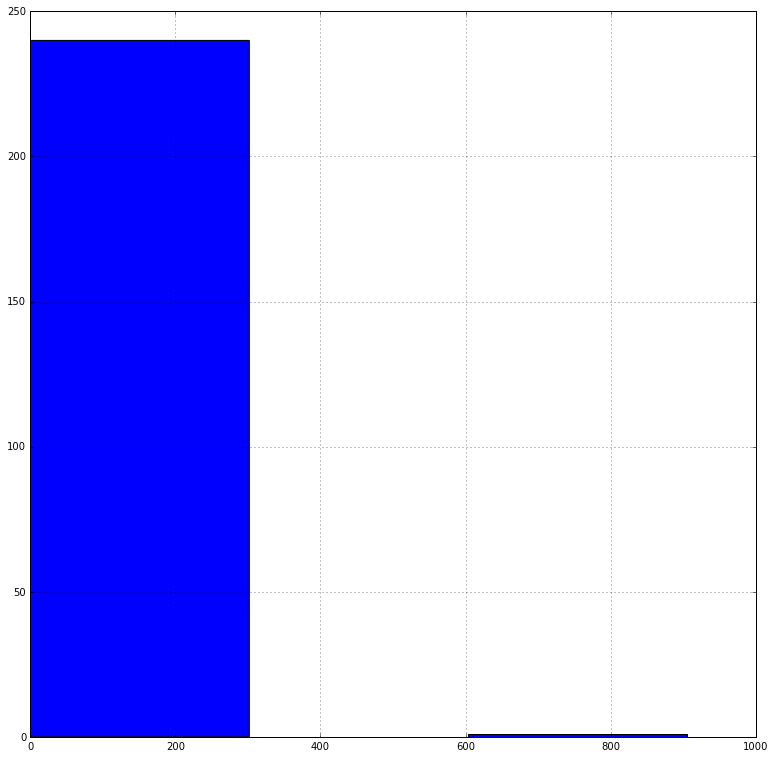

In [31]:
# histogram of the water to land raio for each country
water_land_ratio['water_land_ratio'].hist(figsize = [13,13], bins = 3)
plt.show()